## Quantifying predictive accuracy: Trickier than it seems

### Russell A. Poldrack[1], Grace Huckins[1], and Gael Varoquaux[2]

[1] Department of Psychology and Interdepartmental Neurosciences Program, Stanford University

[2] INRIA

#### Abstract:

There is great interest in developing tools that can predict clinically or scientifically important outcomes from high-dimensional data such as neuroimaging or genomics data.  Our goal in this paper is to highlight several potential pitfalls in predictive modeling. First, we highlight the absolute requirement for any claims of prediction to be tested on data separate from those used to fit the predictive model, which is generally achieved using crossvalidation.  Second, we discuss the use of different possible measures of predictive performance, highlighting the limitations of some commonly used measures and the need for assessment using multiple measures of performance.  Third, we highlight a particular challenge in the application of cross-validation to continuously distributed outcome variables, demonstrating that the naive application of standard cross-validation techniques can result in badly biased results.  Finally, we discuss the use of randomization for null modeling and some challenges in its use.



In [1]:
import numpy,pandas
import seaborn
from sklearn.linear_model import LinearRegression,LogisticRegression,LogisticRegressionCV
from sklearn import model_selection,metrics
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import LeaveOneOut

import matplotlib.pyplot as plt

# this imports a function to do balanced cross validation
from get_balanced_folds import BalancedKFold

%matplotlib inline
# %load_ext rpy2.ipython

#### Introduction

There is currently great interest in the development of "biomarkers" for disease, to serve as diagnostic markers or surrogate endpoints for clinical research. This interest is particular great for neuropsychiatric disorders, given the lack of biological tests for these diseases and their substantial economic and social impact (REF).  The development of such biomarkers generally proceeds through the establishment of a predictive relationship between the measure of interest and the outcome of interest.  However, a broad set of methods are used to establish such relationships.

In this tutorial paper we will review a number of challenges that arise in predictive modeling.  Most of these challenges are well known within the machine learning and statistics communities, though even in those literatures some of these points have not been sufficiently emphasized. We begin by outlining the meaning of the concept of "prediction" from the standpoint of machine learning, a field focused heavily on the development of methods for generalizable predictive models.  We highlight the fact that predictive accuracy cannot be established using the same data to both fit and test the model, which is a common error in published claims of "prediction."   We then turn to the question of how accuracy should be quantified, focusing heavily on the case of continuous outcome measures. We outline the ways in which naive use of particular predictive accuracy measures and crossvalidation methods can lead to strongly biased estimates of predictive accuracy.  We conclude by outlining a set of best practices to establish effective claims of predictive accuracy.


**What does "prediction" mean?**

Let's say that an investigator publishes a report in which they claim to be able to predict a diagnosis of schizophrenia from brain imaging data with 90% accuracy.  Most readers would fairly assume that this implies that the method could be applied in a new sample of individuals with similar accuracy, as this is the common interpretation of the term "prediction".  However, the term "predict" is used in many different ways in the literature, often in ways that would not support the kind of generalizable predictive accuracy that most people expect from such a claim.  

**GRACE REVIEW**



**Overfitting and prediction**

The concept of overfitting is well known to machine learning researchers but may be less familiar to those trained in standard statistical methods.  Any dataset includes contributions from the underlying generative processes that we wish to model, as well as from measurement noise.  When we fit a model to data, our goal is to approximate the underlying process that generated the data.  The standard approach in statistical modeling is to find the model parameters that best fit the observed data, defined as minimizing the difference between the model's fitted values and the observed data (such as the mean squared error). Note that the term "prediction" is often used in this context in statistical software packages: fitted values from the model are often referred to as "predicted" values, and regressors in a linear model are referred to as "predictors".  This language is unfortunate, because it implies that the accuracy of model fit is an index of predictive validity when it is not.

The fit of a model to a specific dataset can always be improved by increasing the number of parameters in the model; with as many parameters as data points, any dataset can be fit perfectly.  However, as the model becomes more complex than the generative process, the fit of the model starts to reflect the specific noise values in the dataset rather than the underlying generative process; this what is referred to as overfitting.  A telltale sign of overfitting is that the model fits well to the specific dataset used to estimate the model, but fits poorly to new datasets sampled from the sample population. Figure 1 presents an example of this, showing how increasing model complexity results in reduced error for the data used to fit the model, but increasingly poor fit as the model becomes more complex than the true data generating process.




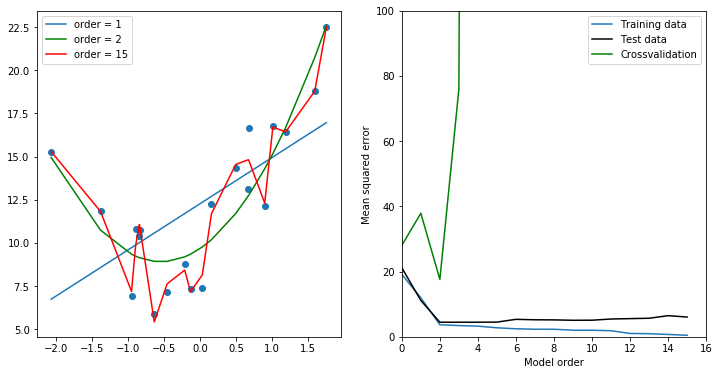

In [2]:
# Figure 1
# true model is quadratic (order 2)
# we generate data from this model and fit models of varying complexity

npts = 20 # number of data points
noise_sd = 2 # noise standard deviation

numpy.random.seed(123456) # set random seed for consistent data

x = numpy.random.randn(npts)
x = numpy.sort(x,axis=None)
x = StandardScaler().fit_transform(x[:,numpy.newaxis])

X = PolynomialFeatures(degree=2).fit_transform(x)
beta=[10,3,3]
Y_train = X.dot(beta) + numpy.random.randn(npts)*noise_sd
Y_test = X.dot(beta) + numpy.random.randn(npts)*noise_sd

coefs={}
model_order_range = 16
mse={'train':numpy.zeros(model_order_range),
    'test':numpy.zeros(model_order_range),
    'cv':numpy.zeros(model_order_range)}

lm = {}
model_X = {}
cv_results = {}

for model_order in range(model_order_range):
    model_X[model_order] = PolynomialFeatures(degree=model_order).fit_transform(x)
    lm[model_order] = LinearRegression(fit_intercept=False)
    lm[model_order].fit(model_X[model_order],Y_train)
    coefs[model_order]=lm[model_order].coef_
    mse['train'][model_order]=numpy.mean((Y_train - lm[model_order].predict(model_X[model_order]))**2)
    mse['test'][model_order]=numpy.mean((Y_test - lm[model_order].predict(model_X[model_order]))**2)
    
    # also compute cross-validation score
    cv_results[model_order] = model_selection.cross_validate(LinearRegression(fit_intercept=False),
                                               model_X[model_order],
                                               Y_train,cv=4,
                                               scoring='neg_mean_squared_error',
                                               return_train_score=False)
    mse['cv'][model_order] = -1*numpy.mean(cv_results[model_order]['test_score'])
   
# plot data points vs model fits

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,Y_train)
plt.plot(x,lm[1].predict(model_X[1]))
plt.plot(x,lm[2].predict(model_X[2]),color='g')
plt.plot(x,lm[15].predict(model_X[15]),color='r')
plt.legend(['order = 1','order = 2','order = 15'])
# perform crossvalidation to estimate out-of-sample fit


# plot MSE

plt.subplot(1,2,2)
plt.plot(mse['train'])
plt.plot(mse['test'],color='k')
plt.plot(mse['cv'],color='g')
plt.axis([0,model_order_range,0,100])
plt.ylabel('Mean squared error')
plt.xlabel('Model order')
plt.legend(['Training data','Test data','Crossvalidation'])

*Figure 1*: A depiction of overfitting.  Left: A simulated dataset generated from a quadratic model (i.e., polynomial order = 2), shown in blue dots.  The best fitting models are shown for order 1 (linear; blue), order 2 (quadratic; green), and order 15 (red).  The complex model clearly overfits the dataset, adapting itself to the noise evident in specific datapoints.  Right: The mean squared error (MSE) for the model assessed against the dataset used to train the model (blue), and against a separate dataset sampled from the same generative process with different random measurement error (black).  The MSE decreases for the training dataset as the complexity increases, whereas for the test dataset the MSE is lowest for order = 2 (i.e. the true model).  The MSE estimated using cross validation (green) is also lowest for the true model; note that it takes very large values for model orders greater than 3, falling outside the axes of the chart.

Because we don't generally have a separate test dataset to assess the generalization of our model, the standard approach in machine learning to address overfitting is to assess model fit using *crossvalidation*, which uses subsets of the data to iteratively train and test the predictive performance of the model.  The simplest form of crossvalidation is known as *leave-one-out*, in which case the model is fitted while iteratively leaving out each data point and then predicting the value of the left-out point.  A more general crossvalidation approach is known as *K-fold crossvalidation*, in which the data are split into *K* different subsets, and the model is successively trained on the remainder of the data (leaving out each subset) and then testing the predictive performance of the model on the held-out subset.  As shown in Figure 1, this approach can also help discover the model that will provide the best predictive performance on other data.

#### How optimistic are in-sample model fits?



As shown above, it is very common for investigators to report estimates of in-sample model fit in service of claims about "prediction". However, the concept of overfitting (and the related concept of "shrinkage" - Copas REF) suggests that any model is likely to fit better to the dataset used to estimate the model, compared to a new dataset sampled from the same population.  This means that any estimate of model fit obtained from a dataset will be an overly optimistic estimate of the true predictive accuracy on a new dataset, because the in-sample estimate is not a true prediction, but rather a post-diction based on knowing the exact data (signal and noise).

The left panel of Figure 2 shows an example of how the optimism of in-sample fits depends on the nature of the statistical model -- in this case, we use a simple linear model but vary the number of irrelevant independent variables in the model. As the number of variables increases, the fit of the model to the sample increases, due to overfitting.  Even for a single variable, the fit of the model is inflated compared to new data or crossvalidation, which provide very similar estimates of out-of-sample predictive accuracy.  The optimism of in-sample fits is also a function of sample size, as shown in the right panel of Figure 2.  

In [9]:
## Simulate optimism as a function of model size

def logistic_simulation(npts = 100, p_disease = 0.5,
                        nvars = 40, noise_sd = 2.5,
                        betaval=2,cv=4):
    # design matrix
    # first column reflects healthy (0) vs disease (1)
    # remaining columns are random noise
    X = numpy.zeros((npts,1))
    X[:int(npts*p_disease)]=1
    X = X - numpy.mean(X)
    if nvars > 1:
        noise = numpy.random.randn(npts*(nvars-1)).reshape((npts,nvars-1))
        noise = StandardScaler().fit_transform(noise)
        X = numpy.hstack((X,noise))
    betas = numpy.zeros(nvars)

    # only the disease variable has true relationship
    betas[0] = betaval
    Y = X.dot(betas) + numpy.random.randn(npts)*noise_sd
    Y = (Y > 0).astype('int')

    # create a new dataset to compare to CV
    Y_new = X.dot(betas) + numpy.random.randn(npts)*noise_sd
    Y_new = (Y_new > 0).astype('int')


    acc = {'insample':numpy.zeros(nvars),
           'newdata':numpy.zeros(nvars),
           'cv':numpy.zeros(nvars)}


    lr = LogisticRegression(solver='lbfgs')

    for i in range(nvars):
        X_i = X[:,:(i+1)]
        lr.fit(X_i,Y)
        acc['insample'][i] = metrics.accuracy_score(Y,lr.predict(X_i))
        acc['newdata'][i] = metrics.accuracy_score(Y_new,lr.predict(X_i))

        cv_results = model_selection.cross_validate(LogisticRegression(solver='lbfgs'),
                                                   X_i,
                                                   Y,cv=cv,
                                                   scoring='accuracy',
                                                   return_train_score=False)
        acc['cv'][i] = numpy.mean(cv_results['test_score'])

    return(acc)



In [13]:
# run simulations
acc_estimates = []
nruns = 100
nvars=40
for i in range(nruns):
    acc_estimates.append(logistic_simulation(betaval=0,
                                             nvars=nvars))
    
# summarize accuracy data
acc = {'insample':[],
        'newdata':[],
        'cv':[]}

for i in range(len(acc_estimates)):
    for k in acc:
        if i == 0:
            acc[k] = acc_estimates[i][k]
        else:
            acc[k] = numpy.vstack((acc[k],acc_estimates[i][k]))

for k in acc:
    acc[k] = numpy.mean(acc[k],0)



In [14]:
# simulate overfitting as a function of sample size

acc_estimates_sampsize = {}
nruns = 1000
sampsizes = 2**numpy.arange(5,10)

for i,sampsize in enumerate(sampsizes):
    acc_estimates_sampsize[sampsize] = []
    for j in range(nruns):
        acc_estimates_sampsize[sampsize].append(logistic_simulation(npts=sampsize,
                                                                nvars=5,betaval=0))
        
# summarize sample size data
acc_sampsize = {'insample':numpy.zeros((nruns,len(sampsizes))),
        'newdata':numpy.zeros((nruns,len(sampsizes))),
        'cv':numpy.zeros((nruns,len(sampsizes)))}


for i in range(nruns): # simulations
    for j,sampsize in enumerate(sampsizes): # sample sizes
        for k in acc_sampsize: # measures 
            acc_sampsize[k][i,j] = acc_estimates_sampsize[sampsize][i][k][0]

for k in acc:
    acc_sampsize[k] = numpy.mean(acc_sampsize[k],0)



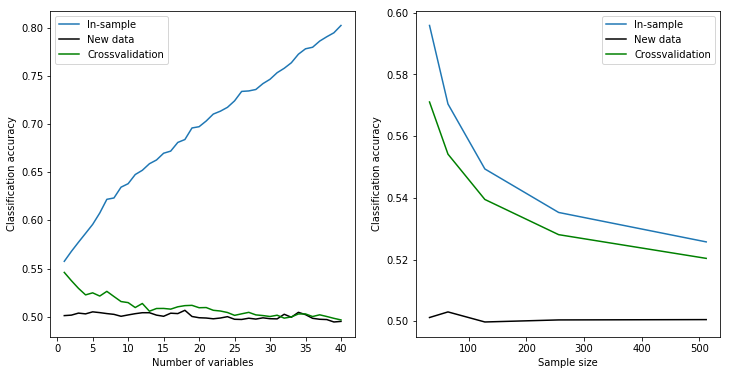

In [15]:

# make figure
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(numpy.arange(1,nvars+1),acc['insample'])
plt.plot(numpy.arange(1,nvars+1),acc['newdata'],'k')
plt.plot(numpy.arange(1,nvars+1),acc['cv'],'g')
plt.ylabel('Classification accuracy')
plt.xlabel('Number of variables')
plt.legend(['In-sample','New data','Crossvalidation'])




# plot sample size data
plt.subplot(1,2,2)
plt.plot(sampsizes,acc_sampsize['insample'])
plt.plot(sampsizes,acc_sampsize['newdata'],'k')
plt.plot(sampsizes,acc_sampsize['cv'],'g')
plt.ylabel('Classification accuracy')
plt.xlabel('Sample size')
plt.legend(['In-sample','New data','Crossvalidation'])



*Figure 2*: Left panel: Classification accuracy as a function of the number of variables in the model.  The data were generated using a single variable (which is the first variable in the list of variables); the remaining variables were simply random normal variables with no intended relationship to the outcome.  The blue line shows that in-sample classification accuracy is heavily inflated by the presence of unrelated variables in the model, due to the fitting of noise in those variables. The black line shows the results for testing the fitted model to a new dataset generated in the same way, and the green line shows the accuracy results using crossvalidation.  Crossvalidation prevents the inflated estimate of prediction accuracy, providing an estimate that is much more similar to that expected with a new dataset.  Right panel: Classification accuracy for the model with 5 variables (1 true generating variable and 4 noise variables) as a function of sample size.  Optimism (the difference between in accuracy between in-sample and crossvalidated/new data accuracy) is substantially higher for smaller sample sizes. 

#### Quantifying classification accuracy

In a classification problem, we wish to quantify our ability to accurately predict class membership, such as the presence of a disease or a cognitive state.  When the number of members in each class is equal, then average accuracy (i.e. the proportion of correct classifications, as used in the examples in Figure 2) is a reasonable measure of predictive accuracy.  However, if there is any imbalance between the frequencies of the different classes, then this is a misleading measure.  Take the following example of a predictive model for a disease that occurs in one out of every 1000 individuals:

|       Test result/Disease        | No disease | Disease |
|---------------|------------|---------|
| Predict disease | 0          | 0       |
| Predict no disease | 999        | 1       |




In [ ]:
disease = numpy.zeros(1000)
disease[0] = 1
prediction = numpy.zeros(1000)
print(metrics.accuracy_score(disease,prediction))
print(metrics.balanced_accuracy_score(disease,prediction))



In this case, our classifier predicts that no one has the disease, but its average accuracy is 99.9%, because of the low frequency of the disease.  A measure commonly used to address this problem is *balanced accuracy*, which is the average of predictive accuracy for each class. In this example, balanced accuracy is 0.5, correctly reflecting the lack of true predictive performance.  It is generally recommended to use balanced accuracy, since it is equivalent to overall accuracy when classes are equally frequent, but properly accounts for imbalance when it occurs.


**discuss ROC curves?**

**discuss stratified cross validation?**



#### Quantifying predictive accuracy for continuous variables: Here be dragons

It is increasingly common to apply predictive modeling in cases where the outcome variable is continuous rather than discrete -- that is, in regression rather than classification problems. For example, a number of studies in cognitive neuroscience have attempted to predict behavioral measures such as IQ or personality test scores from neuroimaging data (REFS).  A predictive analysis using regression requires two important choices --  crossvalidation method and measure of predictive accuracy -- and both of these have the potential to result in misleading results.

First we demonstrate the problem, and then outline its cause and solutions.  Let's say that we have collected data for a study with the aim of predicting some physical quantity based on some measured variable, but our detector for the physical quantity is broken, such that it only reflects random measurement noise.  To quantify our predictive accuracy, we perform leave-one-out crossvalidation using linear regression, and we quantify our predictive accuracy by computing the correlation between predicted values and true values, and squaring that value to give us an "r-squared", which is a measure of the amount of variance accounted for in the data. 

Figure 3 shows the simulated data on the left, showing no relation between X and Y.   Naively we would expect that our predictive accuracy is zero, since the data comprise only measurement noise. However, when we perform crossvalidation and compute predictive accuracy by squaring the correlation between observed and predicted values, we see that we can predict almost 70% of the variance using our model!  The right panel in Figure 3 shows that this reflects the fact that the predicted values are actually negatively correlated with the true values, and squaring this negative correlation coefficient gives us a positive r-squared.  

In [ ]:
## generate null data and perform regression cross-validation
numpy.random.seed(12345)
npts = 40
X = numpy.random.randn(npts)
y = numpy.random.randn(npts)

loo = LeaveOneOut()
lr = LinearRegression()
pred = numpy.zeros(y.shape)
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train[:,numpy.newaxis],y_train)
    pred[test_index] = lr.predict(X_test[:,numpy.newaxis])
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X,Y)
plt.title('correlation = %0.3f'%numpy.corrcoef(X,Y)[0,1])


plt.subplot(1,2,2)
plt.scatter(y,pred)
plt.title('r^2 = %0.3f, VAF = %0.3f'%(numpy.corrcoef(y,pred)[0,1]**2,
         metrics.r2_score(y,pred)))
plt.xlabel('true value')
plt.ylabel('predicted value')

*Figure 3*: A demonstration of the problematic application of crossvalidation to continuous variables, using random data with no true predictive relationship (shown in the left pane;)  The right panel  shows the true value for each datapoint plotted against the predicted value using leave-one-out crossvalidation; the "r^2" value is obtained by squaring the correlation coefficient, while the variance accounted for (VAF) was computed using the scikit-learn *r2_score()* function.

Why does this negative relationship between predicted and actual values occur?  Figure 4 shows a schematic with a smaller number of data points.  The fundamental problem is that the distribution of X values is different between the different training folds, a problem exacerbated by the use of leave-one-out crossvalidation.  Data points lying on the extremes of the X distribution have substantial leverage on the regression solution, such that leaving them out results in regression lines that are opposite in direction to the line for the full dataset.  This results in predictions that are anticorrelated with the true values.

In [ ]:
# figure showing biased prediction

def abline(slope, intercept,plt_sym='-',color='k'):
    """
    Plot a line from slope and intercept
    adapted from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """
    axes = plt.gca()
    x_vals = numpy.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, plt_sym,color=color)

    
    
numpy.random.seed(1234)
X = numpy.random.randn(8)
Y = numpy.random.randn(8)
idx = numpy.argsort(X)
X = X[idx].reshape((8,1))
Y = Y[idx]

plt.scatter(X,Y,alpha=0.2)
lr = LinearRegression(fit_intercept=True)
lr.fit(X,Y)
abline(lr.coef_[0],lr.intercept_)
for i in range(8):
    plt.annotate('%d'%int(i+1),[X[i],Y[i]])
    
# compute regression lines, dropping each value
loo = LeaveOneOut()
regparams = numpy.zeros((8,2))
for train_index,test_index in loo.split(X):
    lr.fit(X[train_index],Y[train_index])
    regparams[test_index,:] = [lr.coef_[0],lr.intercept_]
    
abline(regparams[0,0],regparams[0,1],'--','g')
abline(regparams[7,0],regparams[7,1],'--','r')
abline(regparams[4,0],regparams[4,1],'--','b')

plt.legend(['all points','drop 1','drop 8','drop 5'])




*Figure 4*: An example of anti-correlated regression predictions using leave-one-out crossvalidation.  The regression line fitted to the full dataset (solid black line) has a slightly positive slope.  Dropping data points near the overall regression line has little impact on the resulting slope (e.g., dashed blue line showing slope after dropping data point 5), but dropping high-leverage data points at the extremes of the X distribution has major impact on the resulting regression lines (e.g., dashed green and red lines showing impact of dropping points 1 and 8 respectively).

#### Quantifying variance accounted for: "R-squared" versus r^2

A popular metric for predictive accuracy with continuous variables is the coefficient of determination ($R^2$), which quantifies the amount of variance in the data accounted for by a linear model.  This is defined as:

$$
R^2 = 1 - \frac{\text{residual sum of squares}}{\text{total sum of squares}}
$$

The use of the label "r-squared" for the coefficient of determination suggests that it is equivalent to the square of the correlation coefficient between the data and the model predictions -- which it is, when computed on the basis of a model fit to the same data (as long as the model includes an intercept term, which ensures that the mean of the predicted values is the same as the mean of the actual values). However, when the model is fitted to one dataset and then applied to another dataset, then this assumption is violated, and the equivalence between the coefficient of determination and the square of the correlation coefficient no longer holds. This also explains how the value of the coefficient of determination computed as shown above can take on negative values.  This occurs in cases when the residual sum of squares is greater than the total sum of squares in the data, which can occur when the model fits the data worse than the mean of the data.  

For this reason, the shorthand computation of the coefficient of determination via squaring the correlation between the observed and predicted values in crossvalidation should *never* be used as a measure of predictive accuracy. Instead, the amount of explained variance should be computed using the sum of squares formulation (e.g., as implemented in the `r2_score()` function in scikit-learn).

#### Cross validation requires large samples

Previous work (Varoquaux, 2017, CV Failure) has highlighted the problems with application of cross-validation with small samples, focusing primarily on the variability of accuracy estimates.  However, small samples also exacerbate the problem highlighted here, due to the relatively stronger effects of individual data points. In Figure 5 we explore the relationship between sample size and predictive accuracy bias, both in the context of no true relationship (top row) and in the context of a moderately strong relationship (bottom row). In addition to leave-one-out crossvalidation, we also include two other crossvalidation methods, to show that crossvalidation methods can have important impacts on resulting accuracy estimates.

There are several points evident from Figure 5.  First, the combination of leave-one-out crossvalidation and correlation as a measure of predictive performance is badly biased; when there is no signal the correlation is negative, and when there is true signal it is heavily underestimated.  Second, this bias is particular problematic at small sample sizes.  Third, all crossvalidation methods exhibit this bias, though to a lesser extent for K-fold or balanced K-fold crossvalidation (which finds folds with similar distributions on the Y variable).  Fourth, mean squared error performs much better as a measure of predictive performance, particularly when using leave-one-out crossvalidation; K-fold methods show somewhat inflated MSE estimates compared to leave-one-out. Fifth, in-sample predictive accuracy shows a bias with small samples, such that positive correlation between predicted and true values is observed even when there is no true relationship.



In [ ]:
def cvtest(nsubs,cv_fns=None,beta=0.2,
           scale_X=True,scale_Y=True,
          scale_within_loop=False):
    """
    - function to perform a single simulation run
    nsubs: number of subjects per simulation
    cv_fns: dict of CV functions
    beta: strength of true relationship
    measure: 'corr': correlation, 'MSE': mean squared error
    """
    results_corr=[]
    results_mse=[]
    
    if cv_fns is None:
        cv_fns={'LOO':model_selection.LeaveOneOut(),
               'BalancedKFold':BalancedKFold(nfolds=4,pthresh=0.99),
               'KFold':model_selection.KFold(n_splits=4,shuffle=True)}

    # just use simple linear regression
    clf=LinearRegression()
    
    # create random X and Y variables
    X=numpy.random.randn(nsubs).reshape((nsubs,1))
    if scale_X:
        X = (X - numpy.mean(X))/numpy.std(X)
    Y=numpy.random.randn(nsubs).reshape((nsubs,1)) + X*beta
    if scale_Y:
        Y = (Y - numpy.mean(Y))/numpy.std(Y)

    scaler=StandardScaler()
    # first run leave-one-out CV
    for method in cv_fns:
        cv=cv_fns[method]
        pred=numpy.zeros((nsubs,1))
        for train_index, test_index in cv.split(X,Y):

            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scale_within_loop:
                X_train=scaler.fit_transform(X_train)
                X_test=scaler.transform(X_test)
            clf.fit(X_train,y_train)

            pred[test_index,0]=clf.predict(X_test)[:,0]
        corr=metrics.r2_score(pred[:,0],Y[:,0])  #numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
        MSE=numpy.sqrt(numpy.mean((pred-Y[:,0])**2))
        results_corr.append([method,corr])
        results_mse.append([method,MSE])
    # also include in-sample
    clf.fit(X,Y)
    pred=clf.predict(X)
    corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
    MSE=numpy.sqrt(numpy.mean((pred-Y[:,0])**2))
    results_corr.append(['insample',corr])
    results_mse.append(['insample',MSE])
    return(results_corr,results_mse)
    
def plot_results(results,beta,measure):
    results_df = pandas.DataFrame(results,columns=['n','method',measure])
    seaborn.barplot(x='n',y=measure,hue='method',data=results_df)
    plt.title('beta = %0.3f'%beta)
    if measure=='MSE':
        plt.ylim((0.98,1.08))
        plt.ylabel('Mean squared error')
    elif measure=='corr':
        plt.ylabel('Correlation(predicted,true)')
 

def run_sim(nruns,beta,
            sampsizes=[24,48,96,192,512,1024]):
    results_corr=[]
    results_mse=[]
    for n in sampsizes:
        for run in range(nruns):
            result_corr,result_mse=cvtest(n,beta=beta)
            for r in result_corr:
                results_corr.append([n]+r)
            for r in result_mse:
                results_mse.append([n]+r)
                
    return(results_corr,results_mse)

In [ ]:
beta=.2
results_corr,results_mse=run_sim(nruns=100,beta=beta)

beta_null=0.
results_corr_nosig,results_mse_nosig=run_sim(nruns=100,beta=beta_null)

In [ ]:
# Make figure

plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
plot_results(results_corr,beta,'corr')

plt.subplot(2,2,2)
plot_results(results_mse,beta,'MSE')

plt.subplot(2,2,3)
plot_results(results_corr_nosig,beta_null,'corr')

plt.subplot(2,2,4)
plot_results(results_mse_nosig,beta_null,'MSE')

Based on the foregoing results, we have several suggestions for best practices in the use of regression methods for prediction of continuous outcome variables:

* Prediction analyses should never be performed with samples smaller than about 100.
* Multiple measures of prediction accuracy should always be examined and reported. In particular, measures of correlation or variance accounted for (such as r-squared) should always be accompanied by measures of average error (such as mean squared error or mean absolute error).
* Results should be confirmed with multiple forms of cross-validation.
* Performance of the prediction model under the null should be assessed by repeatedly running the entire prediction pipeline while randomly shuffling the outcome variable.  This assumes that observations are exchangeable, which can fail in cases where there are relationships between data points.


#### Crossvalidation in the context of structure

It is increasingly common for researchers to examine data in which the observations are not independent. 



In [ ]:
## simulate random effect of family


def family_sim(person_sd=1,family_sd=1,
               nfamilies=10,nperfamily=10):

    npts = nperfamily * nfamilies

    family_effect = numpy.random.randn(nfamilies)*family_sd
    family_labels = numpy.kron(numpy.arange(nfamilies),numpy.ones(nperfamily))
    families = numpy.kron(family_effect,numpy.ones(nfamilies))

    X = numpy.random.randn(npts) + families
    Y = X + numpy.random.randn(npts)*person_sd
    Y_new = X + numpy.random.randn(npts)*person_sd

    X = X.reshape((npts,1))
    
    cv_results_logo = model_selection.cross_validate(LinearRegression(),
                                                X,Y,
                                                cv=model_selection.LeaveOneGroupOut(),
                                                groups=family_labels,
                                                scoring='neg_mean_squared_error',
                                                return_train_score=True)
    cv_results_kfold = model_selection.cross_validate(LinearRegression(),
                                                X,Y,
                                                cv=model_selection.KFold(n_splits=nfamilies,
                                                                         shuffle=True),
                                                scoring='neg_mean_squared_error',
                                                return_train_score=True)


    lr = LinearRegression(fit_intercept=True)
    lr.fit(X,Y)
    acc_insample = metrics.mean_squared_error(Y,lr.predict(X))
    acc_newdata = metrics.mean_squared_error(Y_new,lr.predict(X))
    
    results = [acc_insample,acc_newdata,
                -1*numpy.mean(cv_results_logo['test_score']),
                -1*numpy.mean(cv_results_kfold['test_score'])]

    return(results,X)

In [ ]:
nruns = 100
acc = []


for i in range(nruns):
    results,X = family_sim(family_sd=5)
    acc.append(results)

    

In [ ]:
print(numpy.mean(acc,0))


In [ ]:
plt.plot(X)

In [ ]:
family_labels